# Imports

In [7]:
import os
import json
import math
import numpy as np 
import matplotlib.pyplot as plt


## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

In [8]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda:0


# Getting datasets from google drive

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
!unzip './drive/MyDrive/cnn/trafic_32.zip'

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
   creating: trafic_32/00014/00000_00009/
  inflating: trafic_32/00014/00000_00009/00000_00009.jpg  
   creating: trafic_32/00014/00010_00017/
  inflating: trafic_32/00014/00010_00017/00010_00017.jpg  
   creating: trafic_32/00014/00012_00001/
  inflating: trafic_32/00014/00012_00001/00012_00001.jpg  
   creating: trafic_32/00014/00021_00028/
  inflating: trafic_32/00014/00021_00028/00021_00028.jpg  
   creating: trafic_32/00014/00001_00004/
  inflating: trafic_32/00014/00001_00004/00001_00004.jpg  
   creating: trafic_32/00014/00018_00022/
  inflating: trafic_32/00014/00018_00022/00018_00022.jpg  
   creating: trafic_32/00014/00002_00001/
  inflating: trafic_32/00014/00002_00001/00002_00001.jpg  
   creating: trafic_32/00014/00020_00016/
  inflating: trafic_32/00014/00020_00016/00020_00016.jpg  
   creating: trafic_32/00014/00002_00012/
  inflating: trafic_32/00014/00002_00012/00002_00012.jpg  
   creating: trafic_32/000

In [11]:
drive.flush_and_unmount()

# Data preparation


In [12]:
transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

images = torchvision.datasets.ImageFolder("./trafic_32/", transform=transform)

trainloader = torch.utils.data.DataLoader(images, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [13]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

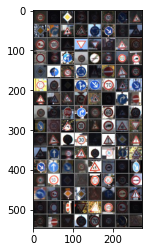

In [14]:
dataiter = iter(trainloader)
images, _ = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

# Building autoencoder

In [15]:
class Encoder(nn.Module):
    
    def __init__(self, 
                 num_input_channels : int, 
                 base_channel_size : int, 
                 latent_dim : int, 
                 act_fn : object = nn.GELU):
        """
        Inputs: 
            - num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the encoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=3, padding=1, stride=2), # 32x32 => 16x16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 16x16 => 8x8
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 8x8 => 4x4
            act_fn(),
            nn.Flatten(), # Image grid to single feature vector
            nn.Linear(2*16*c_hid, latent_dim)
        )
    
    def forward(self, x):
        return self.net(x)

In [16]:
class Decoder(nn.Module):
    
    def __init__(self, 
                 num_input_channels : int, 
                 base_channel_size : int, 
                 latent_dim : int, 
                 act_fn : object = nn.GELU):
        """
        Inputs: 
            - num_input_channels : Number of channels of the image to reconstruct. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the last convolutional layers. Early layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the decoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 2*16*c_hid),
            act_fn()
        )
        self.net = nn.Sequential(
            nn.ConvTranspose2d(2*c_hid, 2*c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 4x4 => 8x8
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(2*c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 8x8 => 16x16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(c_hid, num_input_channels, kernel_size=3, output_padding=1, padding=1, stride=2), # 16x16 => 32x32
            nn.Tanh() # The input images is scaled between -1 and 1, hence the output has to be bounded as well
        )
    
    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4)
        x = self.net(x)
        return x

In [17]:
class Autoencoder(nn.Module):
    
    def __init__(self, 
                 base_channel_size: int, 
                 latent_dim: int, 
                 encoder_class : object = Encoder,
                 decoder_class : object = Decoder,
                 num_input_channels: int = 3, 
                 width: int = 32, 
                 height: int = 32):
        super().__init__()
        # Creating encoder and decoder
        self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim)
        self.decoder = decoder_class(num_input_channels, base_channel_size, latent_dim)
        # Example input array needed for visualizing the graph of the network
        self.example_input_array = torch.zeros(2, num_input_channels, width, height)
        
    def forward(self, x):
        """
        The forward function takes in an image and returns the reconstructed image
        """
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

In [18]:
autoencoder = Autoencoder(base_channel_size=32, latent_dim=512, encoder_class=Encoder, decoder_class=Decoder).to(device)

In [19]:
criterion = nn.MSELoss(reduction="sum")
optimizer = optim.Adam(autoencoder.parameters(), lr=0.003)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [20]:
num_epochs = 100
for n in range(num_epochs):
    losses_epoch = []
    for x, _ in iter(trainloader):
        x = x.to(device)
        out = autoencoder(x)
        loss = criterion(out, x) 
        losses_epoch.append(loss.item())
        loss.backward()               # backward pass (compute parameter updates)
        optimizer.step()              # make the updates for each parameter
        optimizer.zero_grad()  
    L1_list = []
    for x, _ in iter(trainloader):
        x  = x.to(device)
        out = autoencoder(x)
        L1_list.append(torch.mean(torch.abs(out-x)).item())
    print(f"Epoch {n} loss {np.mean(np.array(losses_epoch))}, test L1 = {np.mean(L1_list)}")
    scheduler.step()

Epoch 0 loss 35017.48750190859, test L1 = 0.14361416424718665
Epoch 1 loss 14324.499413108204, test L1 = 0.10836562997258059
Epoch 2 loss 9886.286035792447, test L1 = 0.09533216119880397
Epoch 3 loss 7555.085689383143, test L1 = 0.08521376589027989
Epoch 4 loss 6398.8062310731375, test L1 = 0.07941070024276013
Epoch 5 loss 5458.497506902738, test L1 = 0.07314640686449865
Epoch 6 loss 4858.121328745292, test L1 = 0.07358773982194813
Epoch 7 loss 4378.416058965925, test L1 = 0.06728704768788155
Epoch 8 loss 4055.8428823862478, test L1 = 0.06480208864429486
Epoch 9 loss 3781.697047727504, test L1 = 0.07031994976758568
Epoch 10 loss 3554.8215729654416, test L1 = 0.06042524378637538
Epoch 11 loss 3281.0484694689026, test L1 = 0.05934435943390337
Epoch 12 loss 3228.211503317768, test L1 = 0.06065456262192043
Epoch 13 loss 2971.4305233038986, test L1 = 0.06126284575035207
Epoch 14 loss 2851.018145135637, test L1 = 0.0640484646375288
Epoch 15 loss 2747.8168499974554, test L1 = 0.05427595317752

KeyboardInterrupt: ignored

# Visualize reconstructions

In [21]:
def visualize_reconstructions(model, input_imgs, device):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        reconst_imgs = model(input_imgs.to(device))
    reconst_imgs = reconst_imgs.cpu()
    
    # Plotting
    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10,10))
    else:
        plt.figure(figsize=(15,10))
    plt.title(f"Reconstructions")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

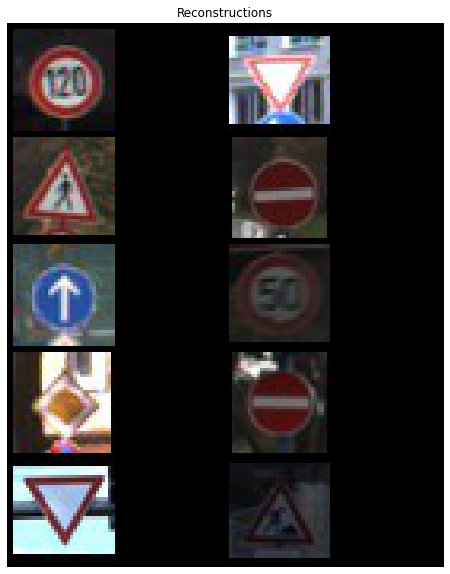

In [22]:
input_imgs, _ = next(iter(trainloader))
visualize_reconstructions(autoencoder, input_imgs[:10], device)

# VAE

In [23]:
class Encoder(nn.Module):
    
    def __init__(self, 
                 num_input_channels : int, 
                 base_channel_size : int, 
                 latent_dim : int,
                 hidden_dim : int,
                 conv_act_fn : object = nn.GELU):
        """
        Inputs: 
            - num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
        """
        super().__init__()
        c_hid = base_channel_size
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=3, padding=1, stride=2), # 32x32 => 16x16
            conv_act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            conv_act_fn(),
            nn.Conv2d(c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 16x16 => 8x8
            conv_act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            conv_act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 8x8 => 4x4
            conv_act_fn(),
            nn.Flatten(), # Image grid to single feature vector
            nn.Linear(2*16*c_hid, hidden_dim)
        )
        self.fc_mean  = nn.Linear(hidden_dim, latent_dim)
        self.fc_var   = nn.Linear(hidden_dim, latent_dim)

        self.training = True
    
    def forward(self, x):
        x        = self.net(x)
        mean     = self.fc_mean(x)
        log_var  = self.fc_var(x)

        return mean, log_var

In [24]:
class Decoder(nn.Module):
    
    def __init__(self, 
                 num_input_channels : int, 
                 base_channel_size : int, 
                 latent_dim : int, 
                 conv_act_fn : object = nn.GELU):
        """
        Inputs: 
            - num_input_channels : Number of channels of the image to reconstruct. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the last convolutional layers. Early layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the decoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 2*16*c_hid),
            nn.LeakyReLU(0.2)
        )
        self.net = nn.Sequential(
            nn.ConvTranspose2d(2*c_hid, 2*c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 4x4 => 8x8
            conv_act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            conv_act_fn(),
            nn.ConvTranspose2d(2*c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 8x8 => 16x16
            conv_act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            conv_act_fn(),
            nn.ConvTranspose2d(c_hid, num_input_channels, kernel_size=3, output_padding=1, padding=1, stride=2), # 16x16 => 32x32
            nn.Tanh() # The input images is scaled between -1 and 1, hence the output has to be bounded as well
        )
    
    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4)
        x = self.net(x)
        return x

In [25]:
class VAE(nn.Module):
    def __init__(self, 
                 base_channel_size: int, 
                 latent_dim: int,
                 hidden_dim: int,
                 encoder_class : object = Encoder,
                 decoder_class : object = Decoder,
                 num_input_channels: int = 3, 
                 width: int = 32, 
                 height: int = 32):
        super().__init__()
        # Creating encoder and decoder
        self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim, hidden_dim)
        self.decoder = decoder_class(num_input_channels, base_channel_size, latent_dim)
        # Example input array needed for visualizing the graph of the network
        self.example_input_array = torch.zeros(2, num_input_channels, width, height)
        
    def reparameterization(self, mean, var):
        eps = torch.randn_like(mean)
        z = mean + eps * var     
        return z      
                
    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat = self.decoder(z)
        return x_hat, mean, log_var

## KLD Loss

In [26]:
def KLD(x, x_hat, mean, log_var):
  reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
  KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
  return reproduction_loss + KLD


In [27]:
vae = VAE(base_channel_size=32, latent_dim=512, hidden_dim=512, encoder_class=Encoder, decoder_class=Decoder).to(device)

In [28]:
optimizer = optim.Adam(vae.parameters(), lr=0.005)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [38]:
vae.train()
num_epochs = 25
for n in range(num_epochs):
    losses_epoch = []
    for x, _ in iter(trainloader):
        x = x.to(device)
        out, means, log_var = vae(x)
        loss = KLD(x, out, means, log_var) 
        losses_epoch.append(loss.item())
        loss.backward()               # backward pass (compute parameter updates)
        optimizer.step()              # make the updates for each parameter
        optimizer.zero_grad()  
    L1_list = []
    for x, _ in iter(trainloader):
        x  = x.to(device)
        out, _, _ = vae(x)
        L1_list.append(torch.mean(torch.abs(out-x)).item())
    print(f"Epoch {n} loss {np.mean(np.array(losses_epoch))}, test L1 = {np.mean(L1_list)}")
    scheduler.step()

Epoch 0 loss 16006.237511451547, test L1 = 0.11011456149700022
Epoch 1 loss 15949.706811762011, test L1 = 0.10990094250304691
Epoch 2 loss 15943.350945388844, test L1 = 0.1107909774789981
Epoch 3 loss 15927.099940197475, test L1 = 0.1099085138218799
Epoch 4 loss 15899.41113917447, test L1 = 0.11168558451465364
Epoch 5 loss 15905.899651045907, test L1 = 0.10960433889386709
Epoch 6 loss 15862.656566508042, test L1 = 0.1115720042722233
Epoch 7 loss 15862.968673656353, test L1 = 0.10902240229254825
Epoch 8 loss 15817.982463227809, test L1 = 0.1102170587945062
Epoch 9 loss 15832.348286085098, test L1 = 0.11011157607119712
Epoch 10 loss 15784.15568378461, test L1 = 0.10859702056704593
Epoch 11 loss 15776.08034532777, test L1 = 0.10819286819098438
Epoch 12 loss 15750.02338978522, test L1 = 0.11011055090042977
Epoch 13 loss 15741.262407433327, test L1 = 0.10992639240010942
Epoch 14 loss 15724.799432512214, test L1 = 0.10806839386492677
Epoch 15 loss 15702.737021579804, test L1 = 0.108368429546

# Save model

In [50]:
torch.save(vae.state_dict(), "./vae.pt")

# Load model

In [40]:
vae.load_state_dict(torch.load("./vae"))

<All keys matched successfully>

# Visualize reconstructions

In [41]:
def visualize_reconstructions(model, input_imgs, device):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        reconst_imgs, means, log_var = model(input_imgs.to(device))
    reconst_imgs = reconst_imgs.cpu()
    
    # Plotting
    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10,10))
    else:
        plt.figure(figsize=(15,10))
    plt.title(f"Reconstructions")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

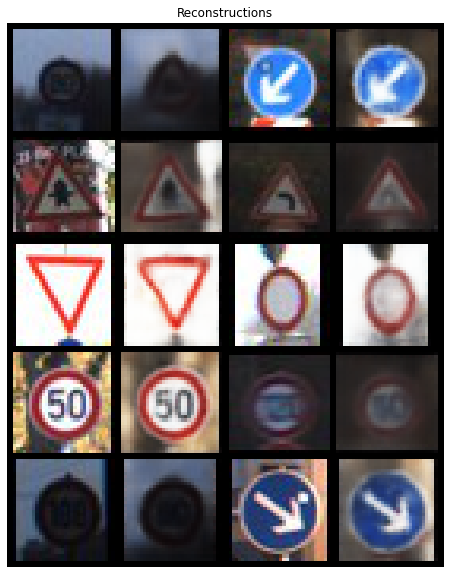

In [43]:
input_imgs, _ = next(iter(trainloader))
visualize_reconstructions(vae, input_imgs[:10], device)

# Generate sample data

In [44]:
from numpy.linalg import norm
def generate_images(model, n_imgs, device, latent_dim, save=False):
    # Generate images
    model.eval()
    with torch.no_grad():
        generated_imgs = model.decoder(torch.randn([n_imgs, latent_dim]).to(device))
    generated_imgs = generated_imgs.cpu()
    
    if (save):
      min = torch.min(generated_imgs)
      max = torch.max(generated_imgs)
      normalized = (generated_imgs - min) / (max - min)
      torch.save(normalized.detach(),"output.pt")
    
    grid = torchvision.utils.make_grid(normalized, nrow=4, normalize=True, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10,10))
    else:
        plt.figure(figsize=(15,10))
    plt.title(f"Generations")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

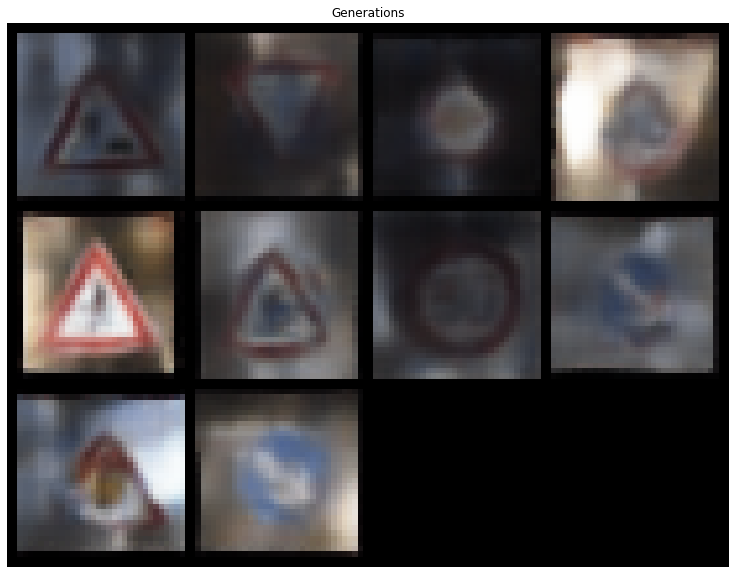

In [49]:
generate_images(vae, 10, device, 512, True)

# Generative Adversarial Networks

In [ ]:
class Discriminator(nn.Module):
    
    def __init__(self, 
                 num_input_channels : int, 
                 base_channel_size : int, 
                 hidden_dim : int,
                 conv_act_fn : object = nn.GELU):
        """
        Inputs: 
            - num_input_channels : Number of input channels of the image. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the first convolutional layers. Deeper layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
        """
        super().__init__()
        c_hid = base_channel_size
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=3, padding=1, stride=2), # 32x32 => 16x16
            conv_act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            conv_act_fn(),
            nn.Conv2d(c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 16x16 => 8x8
            conv_act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            conv_act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 8x8 => 4x4
            conv_act_fn(),
            nn.Flatten(), # Image grid to single feature vector
            nn.Linear(2*16*c_hid, hidden_dim)
        )
        self.fc_1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, 1)
        
        self.act_fn = nn.LeakyReLU(0.2)

        self.training = True
    
    def forward(self, x):
        x        = self.net(x)
        x        = self.act_fn(self.fc_1(x))
        x        = self.act_fn(self.fc_2(x))
        out      = self.fc_out(x)

        return out

In [ ]:
class Generator(nn.Module):
    
    def __init__(self,  
                 latent_dim : int,
                 hidden_dim : int,
                 base_channel_size: int,
                 num_input_channels: int,
                 conv_act_fn : object = nn.GELU):
        """
        Inputs: 
            - num_input_channels : Number of channels of the image to reconstruct. For CIFAR, this parameter is 3
            - base_channel_size : Number of channels we use in the last convolutional layers. Early layers might use a duplicate of it.
            - latent_dim : Dimensionality of latent representation z
            - act_fn : Activation function used throughout the decoder network
        """
        super().__init__()
        c_hid = base_channel_size
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 2*16*c_hid),
            nn.LeakyReLU(0.2)
        )
        self.net = nn.Sequential(
            nn.ConvTranspose2d(2*c_hid, 2*c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 4x4 => 8x8
            conv_act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            conv_act_fn(),
            nn.ConvTranspose2d(2*c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 8x8 => 16x16
            conv_act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            conv_act_fn(),
            nn.ConvTranspose2d(c_hid, num_input_channels, kernel_size=3, output_padding=1, padding=1, stride=2), # 16x16 => 32x32
            nn.Tanh()
        )
    
    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4)
        x = self.net(x)
        return x

In [ ]:
# Models
latent_dim = 256
generator = Generator(latent_dim=latent_dim, hidden_dim=128, base_channel_size=32, num_input_channels=3).to(device)
discriminator = Discriminator(hidden_dim=256, base_channel_size=32, num_input_channels=3).to(device)

# Optimizers
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0001)
generator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=generator_optimizer, gamma=0.99)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001)
discriminator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=discriminator_optimizer, gamma=0.99)

# loss
criterion = nn.MSELoss()

In [ ]:
fixed_noise = torch.randn(64, latent_dim,device=device)

Epoch: 0, discrimiantor fake error: 0.136, discriminator real acc: 0.864


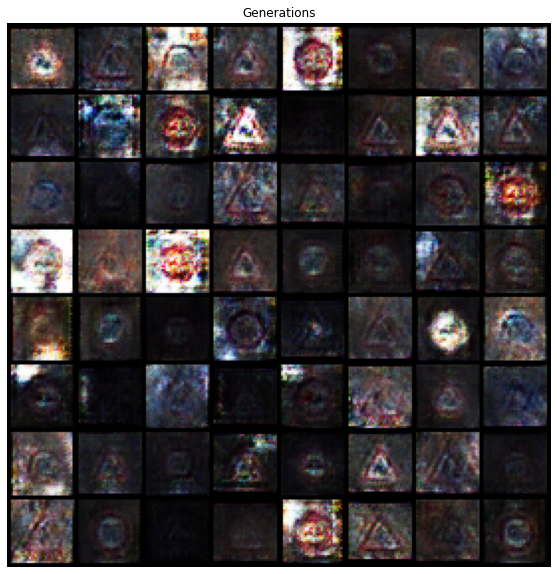

Epoch: 1, discrimiantor fake error: 0.132, discriminator real acc: 0.868
Epoch: 2, discrimiantor fake error: 0.13, discriminator real acc: 0.868
Epoch: 3, discrimiantor fake error: 0.132, discriminator real acc: 0.868
Epoch: 4, discrimiantor fake error: 0.134, discriminator real acc: 0.866
Epoch: 5, discrimiantor fake error: 0.138, discriminator real acc: 0.861
Epoch: 6, discrimiantor fake error: 0.135, discriminator real acc: 0.865
Epoch: 7, discrimiantor fake error: 0.132, discriminator real acc: 0.867
Epoch: 8, discrimiantor fake error: 0.135, discriminator real acc: 0.864
Epoch: 9, discrimiantor fake error: 0.136, discriminator real acc: 0.864
Epoch: 10, discrimiantor fake error: 0.134, discriminator real acc: 0.864


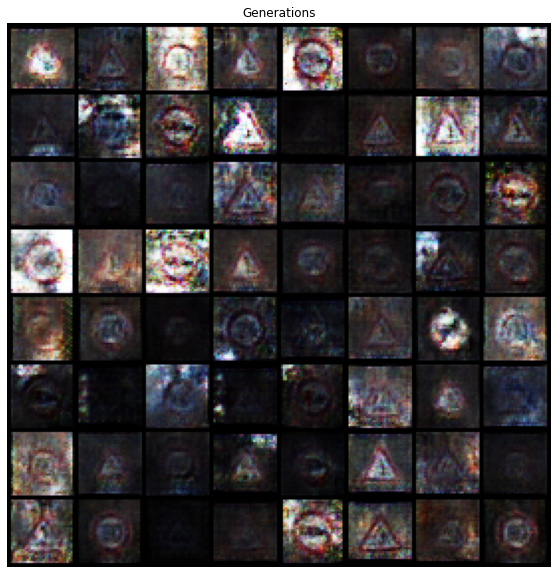

Epoch: 11, discrimiantor fake error: 0.13, discriminator real acc: 0.87
Epoch: 12, discrimiantor fake error: 0.136, discriminator real acc: 0.863
Epoch: 13, discrimiantor fake error: 0.133, discriminator real acc: 0.866
Epoch: 14, discrimiantor fake error: 0.125, discriminator real acc: 0.874
Epoch: 15, discrimiantor fake error: 0.128, discriminator real acc: 0.871
Epoch: 16, discrimiantor fake error: 0.122, discriminator real acc: 0.877
Epoch: 17, discrimiantor fake error: 0.125, discriminator real acc: 0.873
Epoch: 18, discrimiantor fake error: 0.131, discriminator real acc: 0.869
Epoch: 19, discrimiantor fake error: 0.127, discriminator real acc: 0.871
Epoch: 20, discrimiantor fake error: 0.125, discriminator real acc: 0.875


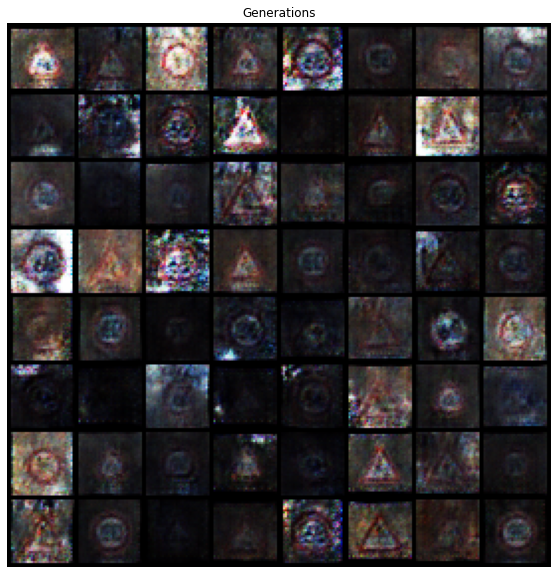

Epoch: 21, discrimiantor fake error: 0.119, discriminator real acc: 0.88
Epoch: 22, discrimiantor fake error: 0.118, discriminator real acc: 0.882
Epoch: 23, discrimiantor fake error: 0.113, discriminator real acc: 0.887
Epoch: 24, discrimiantor fake error: 0.114, discriminator real acc: 0.885
Epoch: 25, discrimiantor fake error: 0.122, discriminator real acc: 0.879
Epoch: 26, discrimiantor fake error: 0.121, discriminator real acc: 0.879
Epoch: 27, discrimiantor fake error: 0.123, discriminator real acc: 0.876
Epoch: 28, discrimiantor fake error: 0.121, discriminator real acc: 0.879
Epoch: 29, discrimiantor fake error: 0.115, discriminator real acc: 0.883
Epoch: 30, discrimiantor fake error: 0.123, discriminator real acc: 0.877


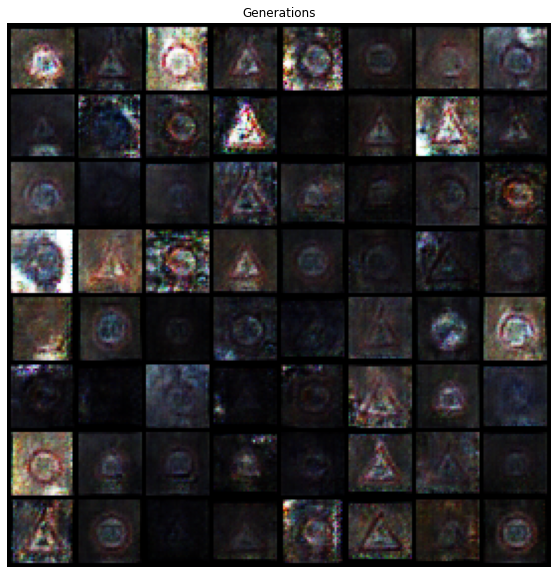

Epoch: 31, discrimiantor fake error: 0.117, discriminator real acc: 0.882
Epoch: 32, discrimiantor fake error: 0.118, discriminator real acc: 0.883
Epoch: 33, discrimiantor fake error: 0.115, discriminator real acc: 0.884
Epoch: 34, discrimiantor fake error: 0.116, discriminator real acc: 0.884
Epoch: 35, discrimiantor fake error: 0.114, discriminator real acc: 0.886
Epoch: 36, discrimiantor fake error: 0.112, discriminator real acc: 0.888
Epoch: 37, discrimiantor fake error: 0.111, discriminator real acc: 0.887
Epoch: 38, discrimiantor fake error: 0.114, discriminator real acc: 0.886
Epoch: 39, discrimiantor fake error: 0.117, discriminator real acc: 0.884
Epoch: 40, discrimiantor fake error: 0.112, discriminator real acc: 0.887


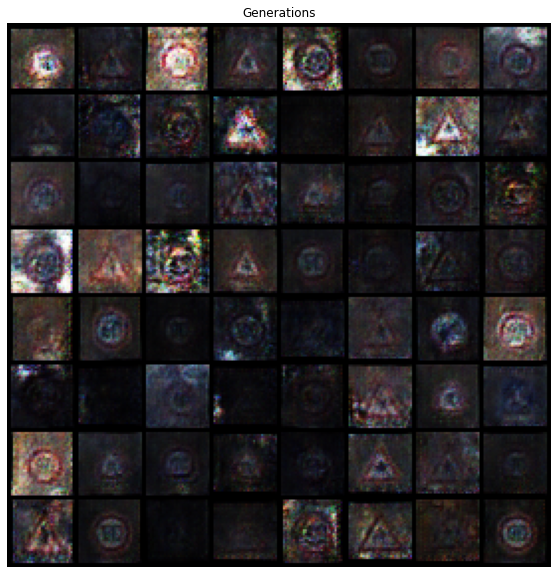

Epoch: 41, discrimiantor fake error: 0.111, discriminator real acc: 0.888
Epoch: 42, discrimiantor fake error: 0.11, discriminator real acc: 0.889
Epoch: 43, discrimiantor fake error: 0.11, discriminator real acc: 0.889
Epoch: 44, discrimiantor fake error: 0.105, discriminator real acc: 0.895
Epoch: 45, discrimiantor fake error: 0.0981, discriminator real acc: 0.902
Epoch: 46, discrimiantor fake error: 0.104, discriminator real acc: 0.896
Epoch: 47, discrimiantor fake error: 0.101, discriminator real acc: 0.898
Epoch: 48, discrimiantor fake error: 0.112, discriminator real acc: 0.888
Epoch: 49, discrimiantor fake error: 0.105, discriminator real acc: 0.894
Epoch: 50, discrimiantor fake error: 0.107, discriminator real acc: 0.892


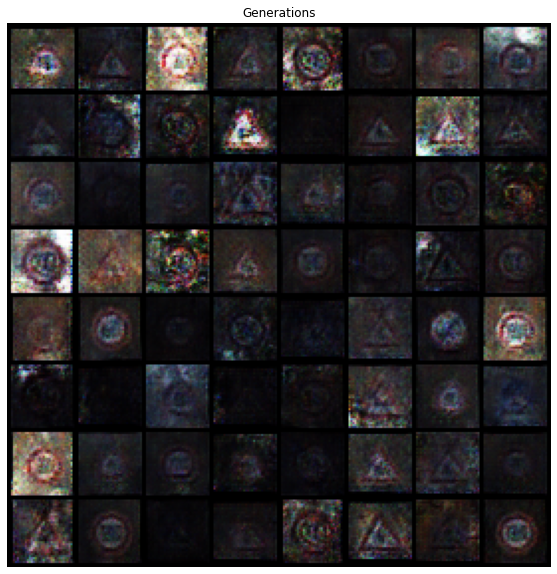

Epoch: 51, discrimiantor fake error: 0.106, discriminator real acc: 0.894
Epoch: 52, discrimiantor fake error: 0.105, discriminator real acc: 0.894
Epoch: 53, discrimiantor fake error: 0.106, discriminator real acc: 0.893
Epoch: 54, discrimiantor fake error: 0.109, discriminator real acc: 0.891
Epoch: 55, discrimiantor fake error: 0.104, discriminator real acc: 0.894
Epoch: 56, discrimiantor fake error: 0.103, discriminator real acc: 0.897
Epoch: 57, discrimiantor fake error: 0.107, discriminator real acc: 0.892
Epoch: 58, discrimiantor fake error: 0.107, discriminator real acc: 0.894
Epoch: 59, discrimiantor fake error: 0.0997, discriminator real acc: 0.9
Epoch: 60, discrimiantor fake error: 0.089, discriminator real acc: 0.912


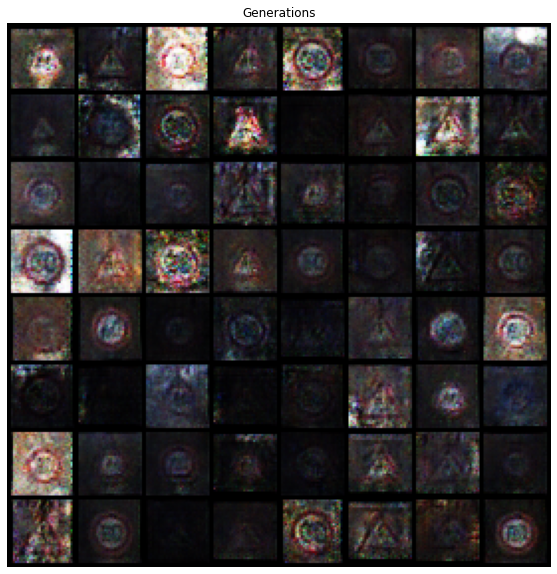

Epoch: 61, discrimiantor fake error: 0.0978, discriminator real acc: 0.901
Epoch: 62, discrimiantor fake error: 0.101, discriminator real acc: 0.898
Epoch: 63, discrimiantor fake error: 0.0985, discriminator real acc: 0.901
Epoch: 64, discrimiantor fake error: 0.0991, discriminator real acc: 0.9
Epoch: 65, discrimiantor fake error: 0.1, discriminator real acc: 0.9
Epoch: 66, discrimiantor fake error: 0.101, discriminator real acc: 0.899
Epoch: 67, discrimiantor fake error: 0.0983, discriminator real acc: 0.901
Epoch: 68, discrimiantor fake error: 0.0951, discriminator real acc: 0.904
Epoch: 69, discrimiantor fake error: 0.0962, discriminator real acc: 0.903
Epoch: 70, discrimiantor fake error: 0.0925, discriminator real acc: 0.907


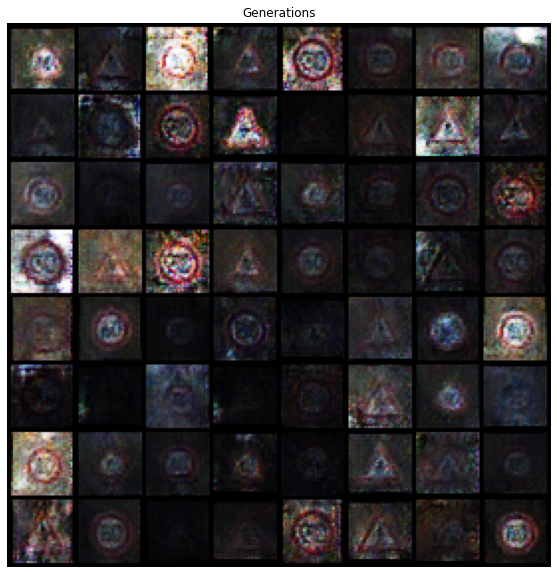

Epoch: 71, discrimiantor fake error: 0.0927, discriminator real acc: 0.906
Epoch: 72, discrimiantor fake error: 0.0925, discriminator real acc: 0.908
Epoch: 73, discrimiantor fake error: 0.0933, discriminator real acc: 0.906
Epoch: 74, discrimiantor fake error: 0.0873, discriminator real acc: 0.911
Epoch: 75, discrimiantor fake error: 0.0931, discriminator real acc: 0.907
Epoch: 76, discrimiantor fake error: 0.0891, discriminator real acc: 0.91
Epoch: 77, discrimiantor fake error: 0.0908, discriminator real acc: 0.909
Epoch: 78, discrimiantor fake error: 0.0866, discriminator real acc: 0.913
Epoch: 79, discrimiantor fake error: 0.0903, discriminator real acc: 0.91
Epoch: 80, discrimiantor fake error: 0.0887, discriminator real acc: 0.911


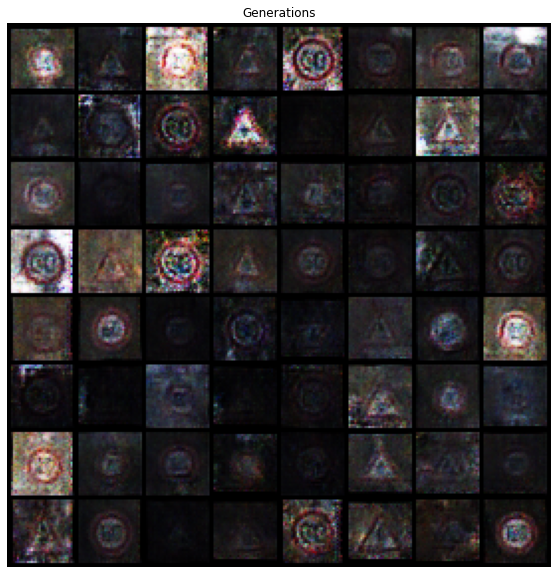

Epoch: 81, discrimiantor fake error: 0.0884, discriminator real acc: 0.912
Epoch: 82, discrimiantor fake error: 0.086, discriminator real acc: 0.913
Epoch: 83, discrimiantor fake error: 0.0871, discriminator real acc: 0.913
Epoch: 84, discrimiantor fake error: 0.087, discriminator real acc: 0.913
Epoch: 85, discrimiantor fake error: 0.0826, discriminator real acc: 0.917
Epoch: 86, discrimiantor fake error: 0.0812, discriminator real acc: 0.919
Epoch: 87, discrimiantor fake error: 0.0819, discriminator real acc: 0.918
Epoch: 88, discrimiantor fake error: 0.0828, discriminator real acc: 0.917
Epoch: 89, discrimiantor fake error: 0.0817, discriminator real acc: 0.918
Epoch: 90, discrimiantor fake error: 0.0846, discriminator real acc: 0.915


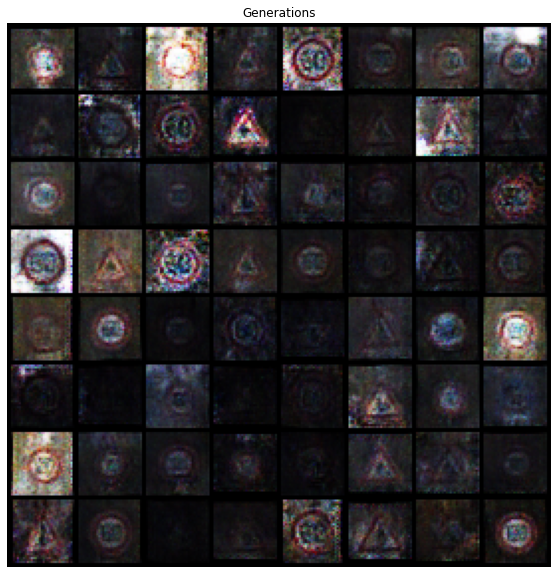

Epoch: 91, discrimiantor fake error: 0.0806, discriminator real acc: 0.918
Epoch: 92, discrimiantor fake error: 0.0767, discriminator real acc: 0.923
Epoch: 93, discrimiantor fake error: 0.0763, discriminator real acc: 0.924
Epoch: 94, discrimiantor fake error: 0.0796, discriminator real acc: 0.92
Epoch: 95, discrimiantor fake error: 0.0818, discriminator real acc: 0.917
Epoch: 96, discrimiantor fake error: 0.0828, discriminator real acc: 0.917
Epoch: 97, discrimiantor fake error: 0.0795, discriminator real acc: 0.92
Epoch: 98, discrimiantor fake error: 0.0808, discriminator real acc: 0.92
Epoch: 99, discrimiantor fake error: 0.0818, discriminator real acc: 0.917


In [ ]:
G_losses = []
D_losses = []
num_epochs = 100
for epoch in range(num_epochs):
    # For each batch in the dataloader
    discriminator_fake_acc = []
    discriminator_real_acc = []
    for i, data in enumerate(trainloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        discriminator_optimizer.zero_grad()
        # Format batch
        real_images = data[0].to(device)
        b_size = real_images.size(0)
        label = torch.ones((b_size,), dtype=torch.float, device=device) # Setting labels for real images
        # Forward pass real batch through D
        output = discriminator(real_images).view(-1)
        # Calculate loss on all-real batch
        error_discriminator_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        error_discriminator_real.backward()
        discriminator_real_acc.append(output.mean().item())

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, latent_dim,device=device)
        # Generate fake image batch with Generator
        fake_images = generator(noise)
        label_fake = torch.zeros((b_size,), dtype=torch.float, device=device)
        # Classify all fake batch with Discriminator
        output = discriminator(fake_images.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        error_discriminator_fake = criterion(output, label_fake)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        error_discriminator_fake.backward()
        discriminator_fake_acc.append(output.mean().item())
        # Compute error of D as sum over the fake and the real batches
        error_discriminator = error_discriminator_real + error_discriminator_fake
        # Update D
        discriminator_optimizer.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        generator_optimizer.zero_grad()
        label = torch.ones((b_size,), dtype=torch.float, device=device)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = discriminator(fake_images).view(-1)
        # Calculate G's loss based on this output
        error_generator = criterion(output, label)
        # Calculate gradients for G
        error_generator.backward()
        D_G_z2 = output.mean().item()
        # Update G
        generator_optimizer.step()

        # Output training stats
        # Save Losses for plotting later
        G_losses.append(error_generator.item())
        D_losses.append(error_discriminator.item())

    print(f"Epoch: {epoch}, discrimiantor fake error: {np.mean(discriminator_fake_acc):.3}, discriminator real acc: {np.mean(discriminator_real_acc):.3}")
    generator_scheduler.step()
    discriminator_scheduler.step()
    if epoch % 10 == 0:
        with torch.no_grad():
            fake = generator(fixed_noise).detach().cpu()
        grid = torchvision.utils.make_grid(fake, normalize=True, range=(-1,1))
        grid = grid.permute(1, 2, 0)
        plt.figure(figsize=(10,10))
        plt.title(f"Generations")
        plt.imshow(grid)
        plt.axis('off')
        plt.show()